# Clinical outcome illustrations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import copy
from classes.clinical_outcome import Clinical_outcome

## Setup

### Shared variables

In [3]:
# Create no-effect arrays:
ivt_time_no_effect_mins = 6.3 * 60
mt_time_no_effect_mins = 8 * 60

In [4]:
# Store utility weightings for mRS 0-6
utility_weights = np.array([0.97, 0.88, 0.74, 0.55, 0.20, -0.19, 0.00])

In [5]:
colour_list = [
    "#0072B2", "#009E73", "#D55E00", "#CC79A7", "#F0E442", "#56B4E9",
    "DarkSlateGray"  # mRS=6
    ]

### mRS distributions

In [6]:
input_mrs_dists = pd.read_csv('data/mrs_dist_probs_cumsum.csv', index_col='Stroke type')

In [7]:
input_mrs_dists

,0,1,2,3,4,5,6
Stroke type,,,,,,,
pre_stroke_nlvo,0.582881,0.745419,0.848859,0.951082,0.993055,1.000000,1.0
pre_stroke_nlvo_ivt_deaths,0.576469,0.737219,0.839522,0.940620,0.982131,0.989000,1.0
pre_stroke_lvo,0.417894,0.560853,0.679283,0.843494,0.957269,1.000000,1.0
pre_stroke_lvo_ivt_deaths,0.403644,0.541728,0.656119,0.814731,0.924626,0.965900,1.0
pre_stroke_lvo_mt_deaths,0.402850,0.540662,0.654829,0.813128,0.922807,0.964000,1.0
no_treatment_nlvo,0.197144,0.460000,0.580032,0.707768,0.855677,0.917702,1.0
no_effect_nlvo_ivt_deaths,0.197271,0.460000,0.577583,0.702252,0.845244,0.904454,1.0
t0_treatment_nlvo_ivt,0.429808,0.630000,0.738212,0.848427,0.929188,0.956300,1.0
no_treatment_lvo,0.050000,0.129000,0.265000,0.429000,0.676000,0.811000,1.0


In [8]:
mrs_dist_names = list(input_mrs_dists.index)

In [9]:
def convert_cumulative_probs_to_mean_mRS_and_utility(cum_dist):
    cum_dist = np.append(0.0, cum_dist)
    vals = np.diff(cum_dist)
    mean_mRS = np.sum(vals * np.arange(7))
    mean_utility = np.sum(vals * utility_weights)
    return mean_mRS, mean_utility

In [10]:
input_mrs_dist_means = dict()
for dist_name in input_mrs_dists.index:
    mean_mrs, mean_utility = \
        convert_cumulative_probs_to_mean_mRS_and_utility(
            input_mrs_dists.loc[dist_name]
            )
    input_mrs_dist_means['mean_mrs_' + dist_name] = mean_mrs
    input_mrs_dist_means['mean_utility_' + dist_name] = mean_utility

### Example pathway and outcome results

In [11]:
example_results = pd.read_csv('./full_outcome_pathway_trial_example_results.csv', index_col=0)

# Keep only the first 100 patients:
example_results = example_results.iloc[0:100]

Explicitly convert arrays containing integers into an integer data type (otherwise the clinical outcome model will reject them):

In [12]:
int_arrays = [
    'onset_time_known_bool',
    'onset_to_arrival_on_time_ivt_bool', 
    'onset_to_arrival_on_time_mt_bool',
    'arrival_to_scan_on_time_ivt_bool',
    'arrival_to_scan_on_time_mt_bool',
    'onset_to_scan_on_time_ivt_bool', 
    'enough_time_for_ivt_bool', 
    'ivt_chosen_bool', 
    'ivt_mask1_onset_known',
    'ivt_mask2_mask1_and_onset_to_arrival_on_time',
    'ivt_mask3_mask2_and_arrival_to_scan_on_time',
    'ivt_mask4_mask3_and_onset_to_scan_on_time',
    'ivt_mask5_mask4_and_enough_time_to_treat',
    'ivt_mask6_mask5_and_treated', 
    'onset_to_scan_on_time_mt_bool',
    'enough_time_for_mt_bool',
    'mt_chosen_bool', 
    'mt_mask1_onset_known', 
    'mt_mask2_mask1_and_onset_to_arrival_on_time',
    'mt_mask3_mask2_and_arrival_to_scan_on_time',
    'mt_mask4_mask3_and_onset_to_scan_on_time',
    'mt_mask5_mask4_and_enough_time_to_treat', 
    'mt_mask6_mask5_and_treated',
    'stroke_type_code'
    ]

example_results[int_arrays] = example_results[int_arrays].astype(dict(zip(int_arrays, ['int' for key in int_arrays])))

Run the outcome model. Make a copy of the results here so that later instances of Clinical_outcome in this notebook don't overwrite the results.

In [13]:
np.random.seed(42)

number_of_patients = len(example_results['stroke_type_code'].values)

# Initiate the outcome model object:
clinical_outcome = Clinical_outcome(input_mrs_dists, number_of_patients)
# Import patient array data:
for key in clinical_outcome.trial.keys():
    if key in list(example_results.columns):
        clinical_outcome.trial[key].data = example_results[key].values

# Calculate outcomes:
results_by_stroke_type, patient_array_outcomes = clinical_outcome.calculate_outcomes()

results_by_stroke_type = copy.copy(results_by_stroke_type)
patient_array_outcomes = copy.copy(patient_array_outcomes)

There are 3 patients with nLVOs and treated with MT, but these patients will not be used in the calculations because there are no mRS distributions for this case. 


/home/anna/samuel_book/outcome_pathway/classes/clinical_outcome.py:852: RuntimeWarning: invalid value encountered in long_scalars
  np.sum(results['each_patient_mean_mrs_shift'] < 0) /
/home/anna/samuel_book/outcome_pathway/classes/clinical_outcome.py:864: RuntimeWarning: Mean of empty slice
  np.nanmean(results['each_patient_mean_mrs_shift'])       # 1 float
/home/anna/samuel_book/outcome_pathway/classes/clinical_outcome.py:866: RuntimeWarning: Mean of empty slice
  np.nanmean(results['each_patient_mean_added_utility'])   # 1 float


## Create colourmaps for mRS and utility

In [14]:
from matplotlib.colors import LinearSegmentedColormap

nodes = np.linspace(0.0, 1.0, len(colour_list))

cmap_mrs = LinearSegmentedColormap.from_list('mrs_continuous', list(zip(nodes, colour_list)))

In [15]:
cmap_utility = plt.get_cmap('binary_r')

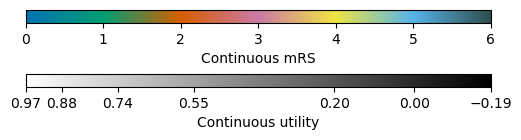

In [168]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

fig, axs = plt.subplots(2, 1, figsize=(6, 1), gridspec_kw={'hspace':4.0})
cbar_mrs = fig.colorbar(ScalarMappable(norm=Normalize(0, 6), cmap=cmap_mrs), label='Continuous mRS', cax=axs[0], orientation='horizontal')
cbar_utility = fig.colorbar(ScalarMappable(norm=Normalize(min(utility_weights), max(utility_weights)), cmap=cmap_utility), label='Continuous utility', cax=axs[1], orientation='horizontal', ticks=utility_weights)

cbar_utility.ax.invert_xaxis()

plt.savefig('./clinical_outcome_worked_example/colour_scales.png', bbox_inches='tight')
plt.show()

Function for sampling colours from these colour maps:

In [17]:
def make_colours(mean_mrs_list, mean_utility_list):

    mean_mrs_colour_list = []
    mean_utility_colour_list = []
    for i, mean_mrs in enumerate(mean_mrs_list):
        mean_mrs_colour_loc = mean_mrs / 6
        mean_mrs_colour = cmap_mrs(mean_mrs_colour_loc)

        mean_utility = mean_utility_list[i]
        mean_utility_colour_loc = ((mean_utility - min(utility_weights)) /
                                   (max(utility_weights) - min(utility_weights)))
        mean_utility_colour = cmap_utility(mean_utility_colour_loc)

        mean_mrs_colour_list.append(mean_mrs_colour)
        mean_utility_colour_list.append(mean_utility_colour)
    if len(mean_mrs_colour_list) == 1:
        return mean_mrs_colour_list[0], mean_utility_colour_list[0]
    else:
        return mean_mrs_colour_list, mean_utility_colour_list


## Plot mRS dists

In [18]:
def plot_bars_and_means(
        axs,
        mrs_dists, labels, mean_mrs_list, mean_mrs_colour_list, mean_utility_list, mean_utility_colour_list, 
        mean_mrs_shift_list=[],
        mean_added_utility_list=[],
        ):
    axis_vals = []
    axis_labels = []

    # fig, axs = plt.subplots(1, 5, figsize=(8, 5), gridspec_kw={'width_ratios':[3.0, 1.5, 0.1, 0.1, 0.1]})#, 'wspace':0.05})
    ax = axs[0]
    ax1 = axs[1]
    # ax_cbar_mrs = axs[2]
    # axs[3].set_visible(False)  # sneaky old gap
    # ax_cbar_utility = axs[4]

    y = 0
    for i, dist_name in enumerate(labels):
        dist = mrs_dists[i]
        cum_vals = np.append(0.0, dist)
        vals = np.diff(cum_vals)

        axis_vals.append(y)
        axis_labels.append(dist_name)
        for v in range(len(vals)):
            label = '' if i > 0 else f'{v}'
            ax.barh(
                y,
                vals[v],
                color=colour_list[v],
                edgecolor='k',
                left=cum_vals[v],
                # height=0.4,
                label=label
                )
            
        xleft = 1.1
        # Mean mRS marker:
        ax1.barh(
            y, 
            0.05, 
            color=mean_mrs_colour_list[i],
            edgecolor='k',
            left=xleft,
            label=''
            )
        ax1.annotate(f'{mean_mrs_list[i]:.2f}', xy=(xleft+0.06, y), ha='left', va='center')
        if i == 0:
            ax1.annotate('Mean mRS', xy=(xleft, 1.0), ha='left')
            
            
        if len(mean_mrs_shift_list) > 0:
            xleft += 0.3
            # # Mean mRS shift marker:
            # ax1.barh(
            #     y, 
            #     0.05, 
            #     color=mean_mrs_shift_colour_list[i],
            #     edgecolor='k',
            #     left=xleft,
            #     label=''
            #     )
            ax1.annotate(f'{mean_mrs_shift_list[i]:.2f}', xy=(xleft+0.06, y), ha='left', va='center')
        
            if i == 0:
                ax1.annotate('shift', xy=(xleft, 1.0), ha='left')
        
        xleft += 0.3
        # Mean utility marker:
        ax1.barh(
            y, 
            0.05, 
            color=mean_utility_colour_list[i],
            edgecolor='k',
            left=xleft,
            label=''
            )
        ax1.annotate(f'{mean_utility_list[i]:.2f}', xy=(xleft+0.06, y), ha='left', va='center')
        if i == 0:
            ax1.annotate('Mean utility', xy=(xleft, 1.0), ha='left')
            
        
        if len(mean_added_utility_list) > 0:
            xleft += 0.3
            # # Mean utility shift marker:
            # ax1.barh(
            #     y, 
            #     0.05, 
            #     color=mean_added_utility_colour_list[i],
            #     edgecolor='k',
            #     left=xleft,
            #     label=''
            #     )
            ax1.annotate(f'{mean_added_utility_list[i]:.2f}', xy=(xleft+0.06, y), ha='left', va='center')

            if i == 0:
                ax1.annotate('shift', xy=(xleft, 1.0), ha='left')

        # Iterate for next row
        y -= 1
        if 'no_treatment' in dist_name:
            y -= 1  # Leave a gap


    if len(mean_mrs_shift_list) > 0:
        ax1.hlines(y+0.5, 1.4, 1.6, color='k')
        ax1.annotate('Mean shift:', xy=(1.16, y), ha='left', va='center')
        ax1.annotate(f'{np.nanmean(mean_mrs_shift_list):.2f}', xy=(1.46, y), ha='left', va='center')
    if len(mean_added_utility_list) > 0:
        ax1.hlines(y+0.5, 2.0, 2.2, color='k')
        ax1.annotate('Mean shift:', xy=(1.76, y), ha='left', va='center')
        ax1.annotate(f'{np.nanmean(mean_added_utility_list):.2f}', xy=(2.06, y), ha='left', va='center')

    ax.set_yticks(axis_vals)
    ax.set_yticklabels(axis_labels)
    ax.set_ylim(axis_vals[-1]-2, axis_vals[0]+1)
    ax.set_xlabel('Cumulative probability')
    for spine in ['top', 'left', 'right']:
        ax.spines[spine].set_visible(False)
    ax.set_xlim(-0.02, 1.02)  # To stop bar outlines being cut off
    ax.legend(ncol=7, bbox_to_anchor=(1.05, 1.2), title='mRS')
    

    for spine in ['top', 'bottom', 'left', 'right']:
        ax1.spines[spine].set_visible(False)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylim(ax.get_ylim())
    ax1.set_xlim(1.05, xleft+0.1)

    # cbar_mrs = plt.colorbar(ScalarMappable(norm=Normalize(0, 6), cmap=cmap_mrs), label='Continuous mRS', cax=ax_cbar_mrs)
    # cbar_utility = plt.colorbar(ScalarMappable(norm=Normalize(min(utility_weights), max(utility_weights)), cmap=cmap_utility), label='Continuous utility', cax=ax_cbar_utility, ticks=utility_weights)
    # cbar_mrs.ax.invert_yaxis()
    
    return fig

In [19]:
input_mrs_dist_names_for_bars = [
    'pre_stroke_nlvo',
    'pre_stroke_nlvo_ivt_deaths',
    't0_treatment_nlvo_ivt',
    'no_effect_nlvo_ivt_deaths',
    'no_treatment_nlvo',
    'pre_stroke_lvo',
    'pre_stroke_lvo_ivt_deaths',
    't0_treatment_lvo_ivt',
    'no_effect_lvo_ivt_deaths',
    'no_treatment_lvo',
    'pre_stroke_lvo',
    'pre_stroke_lvo_mt_deaths',
    't0_treatment_lvo_mt',
    'no_effect_lvo_mt_deaths',
    'no_treatment_lvo',
]

In [20]:
labels = input_mrs_dist_names_for_bars
mrs_dists = [input_mrs_dists.loc[dist_name].tolist() for dist_name in input_mrs_dist_names_for_bars]

mean_mrs_list = []
mean_utility_list = []
for dist in mrs_dists:
    mean_mrs, mean_utility = convert_cumulative_probs_to_mean_mRS_and_utility(dist)
    
    mean_mrs_list.append(mean_mrs)
    mean_utility_list.append(mean_utility)

mean_mrs_colour_list, mean_utility_colour_list = make_colours(mean_mrs_list, mean_utility_list)


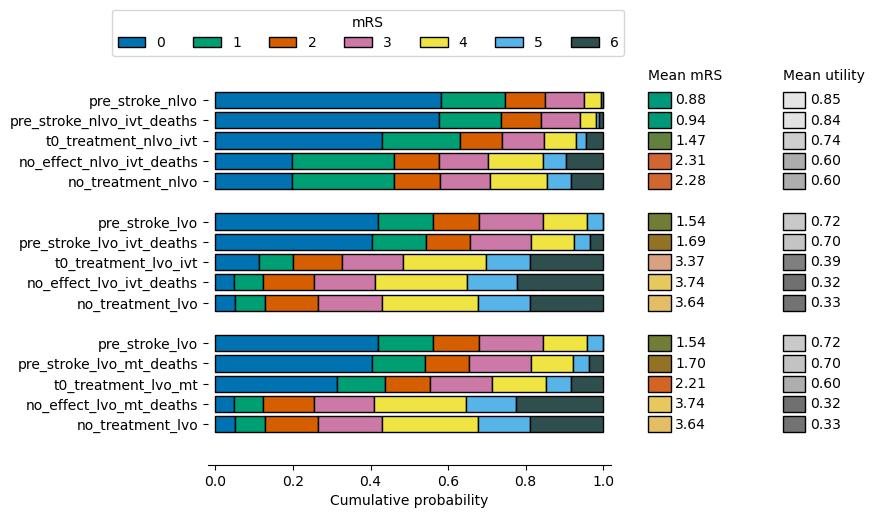

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5), gridspec_kw={'width_ratios':[3.0, 1.5], 'wspace':0.05})
plot_bars_and_means(axs, mrs_dists, labels, mean_mrs_list, mean_mrs_colour_list, mean_utility_list, mean_utility_colour_list)

plt.savefig('clinical_outcome_worked_example/input_mrs_dists.png', bbox_inches='tight')

In [22]:
for dist in mrs_dists:
    # print(dist)
    cum_vals = np.append(0.0, dist)
    vals = np.diff(cum_vals)

    bin_above_median = np.where(cum_vals >= 0.5)[0][0]
    bin_below_median = np.where(cum_vals < 0.5)[0][-1]
    median = bin_below_median +  (0.5 - cum_vals[bin_below_median]) / (cum_vals[bin_above_median] - cum_vals[bin_below_median])
    print(median)

8.578080259950143e-01
0.8673488634934422
1.350624320437245
2.34018460794554
2.3332444381007478
1.574332500926839
1.6978079788030278
4.0714100050532105
4.376300390371157
4.287449392712551
1.574332500926839
1.704944768570881
2.5391736928699347
4.38148099777981
4.287449392712551


The MEDIAN (NOT THE MEAN!!) mRS is the value where cumulative probability is 0.5. Rather than just using the mRS value of the block this 0.5 marker falls into, we see how far along this block the 0.5 marker is to get a fractional mRS.

## Time graphs

In [163]:
def plot_mRS_with_time(
        ax,
        times_for_all_mean_mrs,
        all_mean_mrs_with_time,
        mean_mrs_with_time_colours,
        time_limit_mins,
        mean_mrs_no_treatment,
        mean_mrs_pre_stroke,
        mean_mrs_no_treatment_colour,
        mean_mrs_pre_stroke_colour,
        patient_times,
        patient_mean_mrs,
        patient_mean_mrs_shift,
        patient_labels=[],
        type_str = 'mRS',
        # show_patient_labels=False
        ):
    # Scatter the mean mRS with time line:
    time_mask = np.where(times_for_all_mean_mrs <= time_limit_mins)
    ax.scatter(times_for_all_mean_mrs[time_mask], 
               np.array(all_mean_mrs_with_time)[time_mask], 
               c=np.array(mean_mrs_with_time_colours)[time_mask], 
               s=2)

    
    # Scatter markers for each patient:
    for i, time in enumerate(patient_times):
        if patient_mean_mrs[i] < mean_mrs_no_treatment:
            marker = 7  # Downwards triangle
            patient_label_offset = -0.05 # 0.1
        else:
            marker = 6  # Upwards triangle
            patient_label_offset = 0.02 # -0.1
        ax.scatter(time, patient_mean_mrs[i], marker=marker, zorder=3, color='k')
        ax.vlines(time, mean_mrs_no_treatment, patient_mean_mrs[i], color='k')
        if len(patient_labels) > 0:
            # ax.annotate(patient_labels[i], 
            #             xy=(time, mean_mrs_no_treatment + patient_label_offset), 
            #             rotation=85, va='bottom', ha='center')
            ha = 'left' if type_str == 'mRS' else 'right'
            va = 'top' if type_str == 'mRS' else 'bottom'
            ax.annotate(patient_labels[i], 
                        xy=(time, patient_mean_mrs[i] + patient_label_offset), 
                        rotation=-60, va=va, ha=ha)
        shift_str = f'{patient_mean_mrs_shift[i]:+.2f}' if type_str == 'mRS' else f'{patient_mean_mrs_shift[i]:+.3f}'
        ax.annotate(shift_str, 
                    xy=(time, np.mean([mean_mrs_no_treatment, patient_mean_mrs[i]])), 
                    rotation=90, va='center', ha='right')



    ax.set_ylabel(f'Mean {type_str}')
    ax.set_xlabel('Treatment time (minutes)')

In [139]:
def find_mrs_dists_at_all_times(occlusion_str, treatment_str):
    if occlusion_str == 'nlvo':
        stroke_type_code = 1
    else:
        stroke_type_code = 2

    if '_mt' in treatment_str:
        mt_chosen = 1
        ivt_chosen = 1
    else:
        mt_chosen = 0
        ivt_chosen = 1

    # Calculate mean mRS at all times
    times = np.arange(0.0, mt_time_no_effect_mins)

    np.random.seed(42)

    # Initiate the outcome model object:
    clinical_outcome_for_times = Clinical_outcome(input_mrs_dists, len(times))

    clinical_outcome_for_times.trial['stroke_type_code'].data = np.array([stroke_type_code]*len(times))
    clinical_outcome_for_times.trial['onset_to_needle_mins'].data = times
    clinical_outcome_for_times.trial['ivt_chosen_bool'].data = np.array([ivt_chosen]*len(times))
    clinical_outcome_for_times.trial['onset_to_puncture_mins'].data = times
    clinical_outcome_for_times.trial['mt_chosen_bool'].data = np.array([mt_chosen]*len(times))

    # Calculate outcomes:
    results_for_times_by_stroke_type, patient_array_outcomes_for_times = \
        clinical_outcome_for_times.calculate_outcomes()

    results_for_times_by_stroke_type = copy.copy(results_for_times_by_stroke_type)
    patient_array_outcomes_for_times = copy.copy(patient_array_outcomes_for_times)

    mean_mrs_with_time = []
    mean_utility_with_time = []
    for t, time in enumerate(times):
        cum_dist = results_for_times_by_stroke_type[treatment_str + '_each_patient_post_stroke_mrs_dist'][t]
        mean_mRS, mean_utility = convert_cumulative_probs_to_mean_mRS_and_utility(cum_dist)
        mean_mrs_with_time.append(mean_mRS)
        mean_utility_with_time.append(mean_utility)

    mean_mrs_with_time_colour_list, mean_utility_with_time_colour_list = make_colours(mean_mrs_with_time, mean_utility_with_time)

    return (times, 
            mean_mrs_with_time, 
            mean_utility_with_time, 
            mean_mrs_with_time_colour_list, 
            mean_utility_with_time_colour_list
           )

In [140]:
def gather_arrays(occlusion_str, treatment_str, inds_patients):
    mean_mrs_t0 = input_mrs_dist_means['mean_mrs_t0_treatment_' + treatment_str]
    mean_utility_t0 = input_mrs_dist_means['mean_utility_t0_treatment_' + treatment_str]

    mean_mrs_no_effect = input_mrs_dist_means['mean_mrs_no_effect_' + treatment_str + '_deaths']
    mean_utility_no_effect = input_mrs_dist_means['mean_utility_no_effect_' + treatment_str + '_deaths']

    mean_mrs_no_treatment = input_mrs_dist_means['mean_mrs_no_treatment_' + occlusion_str]
    mean_utility_no_treatment = input_mrs_dist_means['mean_utility_no_treatment_' + occlusion_str]

    mean_mrs_pre_stroke = input_mrs_dist_means['mean_mrs_pre_stroke_' + occlusion_str]
    mean_utility_pre_stroke = input_mrs_dist_means['mean_utility_pre_stroke_' + occlusion_str]

    # Create colours for "no treatment" and "pre-stroke" values:
    mean_mrs_no_treatment_colour, mean_utility_no_treatment_colour = \
        make_colours([mean_mrs_no_treatment], [mean_utility_no_treatment])
    mean_mrs_pre_stroke_colour, mean_utility_pre_stroke_colour = \
        make_colours([mean_mrs_pre_stroke], [mean_utility_pre_stroke])

    (times, 
    mean_mrs_with_time, 
    mean_utility_with_time, 
    mean_mrs_with_time_colour_list, 
    mean_utility_with_time_colour_list
    ) = find_mrs_dists_at_all_times(occlusion_str, treatment_str)

    time_name = 'onset_to_needle_mins' if '_ivt' in treatment_str else 'onset_to_puncture_mins'
    times_patients = example_results[time_name].values[inds_patients]
    mean_mrs_patients = results_by_stroke_type[treatment_str + '_each_patient_post_stroke_mean_mrs'][inds_patients]
    mean_mrs_shift_patients = results_by_stroke_type[treatment_str + '_each_patient_mean_mrs_shift'][inds_patients]
    mean_utility_patients = results_by_stroke_type[treatment_str + '_each_patient_post_stroke_mean_utility'][inds_patients]
    mean_utility_shift_patients = results_by_stroke_type[treatment_str + '_each_patient_mean_added_utility'][inds_patients]

    mean_mrs_colour_patients, mean_utility_colour_patients = make_colours(mean_mrs_patients, mean_utility_patients)
   
    dict_keys = [
        'mean_mrs_t0',
        'mean_utility_t0',
        'mean_mrs_no_effect',
        'mean_utility_no_effect',
        'mean_mrs_no_treatment',
        'mean_utility_no_treatment',
        'mean_mrs_pre_stroke',
        'mean_utility_pre_stroke',
        'mean_mrs_no_treatment_colour', 
        'mean_utility_no_treatment_colour',
        'mean_mrs_pre_stroke_colour', 
        'mean_utility_pre_stroke_colour',
        'times', 
        'mean_mrs_with_time', 
        'mean_utility_with_time', 
        'mean_mrs_with_time_colour_list', 
        'mean_utility_with_time_colour_list',
        'times_patients',
        'mean_mrs_patients',
        'mean_mrs_shift_patients',
        'mean_utility_patients',
        'mean_utility_shift_patients',
        'mean_mrs_colour_patients', 
        'mean_utility_colour_patients',
        'inds_patients',
    ]
    dict_vals = [
        mean_mrs_t0,
        mean_utility_t0,
        mean_mrs_no_effect,
        mean_utility_no_effect,
        mean_mrs_no_treatment,
        mean_utility_no_treatment,
        mean_mrs_pre_stroke,
        mean_utility_pre_stroke,
        mean_mrs_no_treatment_colour, 
        mean_utility_no_treatment_colour,
        mean_mrs_pre_stroke_colour, 
        mean_utility_pre_stroke_colour,
        times, 
        mean_mrs_with_time, 
        mean_utility_with_time, 
        mean_mrs_with_time_colour_list, 
        mean_utility_with_time_colour_list,
        times_patients,
        mean_mrs_patients,
        mean_mrs_shift_patients,
        mean_utility_patients,
        mean_utility_shift_patients,
        mean_mrs_colour_patients, 
        mean_utility_colour_patients,
        inds_patients
    ]
    return dict(zip(dict_keys, dict_vals))

### nLVO with IVT

In [141]:
# Patients with nLVO and IVT:
occlusion_str = 'nlvo'
treatment_str = occlusion_str + '_ivt'
inds_patients = np.where(
    (example_results['stroke_type_code'].values == 1) &
    (example_results['ivt_chosen_bool'].values == 1))[0]

time_shift_dict_nlvo_ivt = gather_arrays(occlusion_str, treatment_str, inds_patients)

### LVO with IVT

In [142]:
# Patients with LVO and IVT:
occlusion_str = 'lvo'
treatment_str = occlusion_str + '_ivt'
inds_patients = np.where(
    (example_results['stroke_type_code'].values == 2) &
    (example_results['ivt_chosen_bool'].values == 1)&
    (example_results['mt_chosen_bool'].values == 0))[0]

time_shift_dict_lvo_ivt = gather_arrays(occlusion_str, treatment_str, inds_patients)

### LVO with MT

In [143]:
# Patients with LVO and IVT:
occlusion_str = 'lvo'
treatment_str = occlusion_str + '_mt'
inds_patients = np.where(
    (example_results['stroke_type_code'].values == 2) &
    (example_results['mt_chosen_bool'].values == 1))[0]

time_shift_dict_lvo_mt = gather_arrays(occlusion_str, treatment_str, inds_patients)

## Combo??

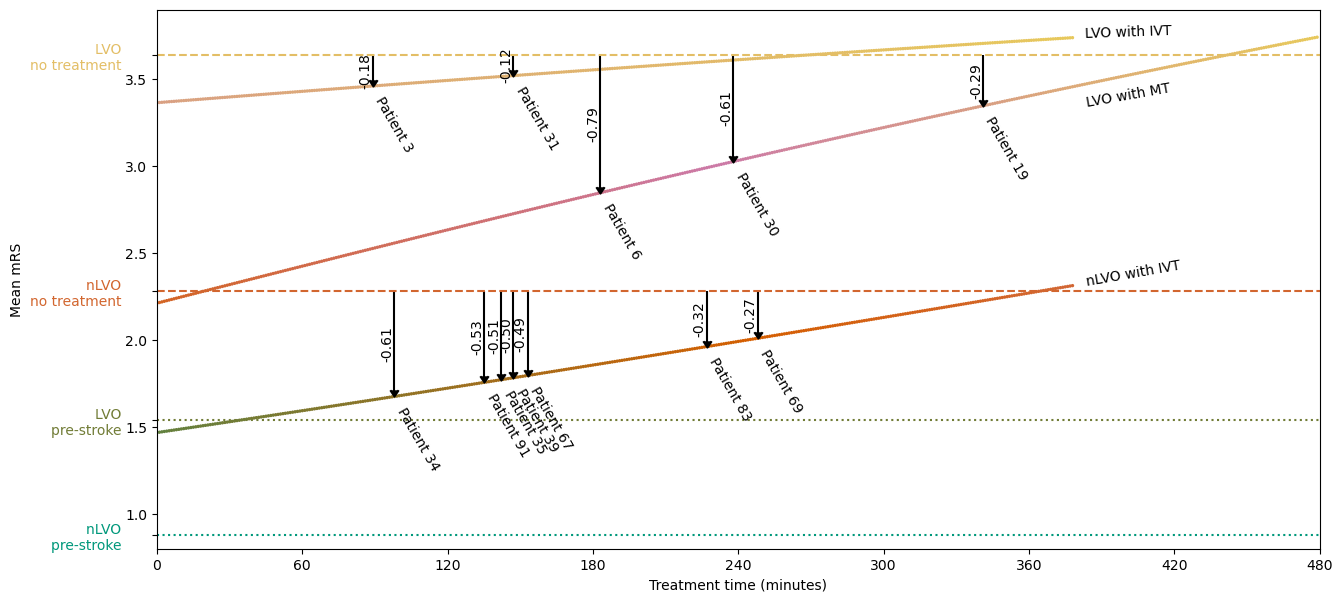

In [173]:
fig, ax = plt.subplots(figsize=(15, 7))

# Patients with nLVO and IVT:
plot_mRS_with_time(
    ax,
    time_shift_dict_nlvo_ivt['times'],
    time_shift_dict_nlvo_ivt['mean_mrs_with_time'],
    time_shift_dict_nlvo_ivt['mean_mrs_with_time_colour_list'],
    ivt_time_no_effect_mins,
    time_shift_dict_nlvo_ivt['mean_mrs_no_treatment'],
    time_shift_dict_nlvo_ivt['mean_mrs_pre_stroke'],
    time_shift_dict_nlvo_ivt['mean_mrs_no_treatment_colour'],
    time_shift_dict_nlvo_ivt['mean_mrs_pre_stroke_colour'],
    time_shift_dict_nlvo_ivt['times_patients'],
    time_shift_dict_nlvo_ivt['mean_mrs_patients'],
    time_shift_dict_nlvo_ivt['mean_mrs_shift_patients'],
    patient_labels=[f'Patient {i}' for i in time_shift_dict_nlvo_ivt['inds_patients']],
    type_str='mRS'
    )



# Patients with LVO and IVT:

plot_mRS_with_time(
    ax,
    time_shift_dict_lvo_ivt['times'],
    time_shift_dict_lvo_ivt['mean_mrs_with_time'],
    time_shift_dict_lvo_ivt['mean_mrs_with_time_colour_list'],
    ivt_time_no_effect_mins,
    time_shift_dict_lvo_ivt['mean_mrs_no_treatment'],
    time_shift_dict_lvo_ivt['mean_mrs_pre_stroke'],
    time_shift_dict_lvo_ivt['mean_mrs_no_treatment_colour'],
    time_shift_dict_lvo_ivt['mean_mrs_pre_stroke_colour'],
    time_shift_dict_lvo_ivt['times_patients'],
    time_shift_dict_lvo_ivt['mean_mrs_patients'],
    time_shift_dict_lvo_ivt['mean_mrs_shift_patients'],
    patient_labels=[f'Patient {i}' for i in time_shift_dict_lvo_ivt['inds_patients']],
    type_str='mRS'
    )


# Patients with LVO and MT:

plot_mRS_with_time(
    ax,
    time_shift_dict_lvo_mt['times'],
    time_shift_dict_lvo_mt['mean_mrs_with_time'],
    time_shift_dict_lvo_mt['mean_mrs_with_time_colour_list'],
    mt_time_no_effect_mins,
    time_shift_dict_lvo_mt['mean_mrs_no_treatment'],
    time_shift_dict_lvo_mt['mean_mrs_pre_stroke'],
    time_shift_dict_lvo_mt['mean_mrs_no_treatment_colour'],
    time_shift_dict_lvo_mt['mean_mrs_pre_stroke_colour'],
    time_shift_dict_lvo_mt['times_patients'],
    time_shift_dict_lvo_mt['mean_mrs_patients'],
    time_shift_dict_lvo_mt['mean_mrs_shift_patients'],
    patient_labels=[f'Patient {i}' for i in time_shift_dict_lvo_mt['inds_patients']],
    type_str='mRS'
    )

type_str = 'mRS'
occlusion_str_list = ['LVO', 'nLVO']
for i, d in enumerate([time_shift_dict_lvo_mt, time_shift_dict_nlvo_ivt]):
    # Horizontal lines for start and end values:
    ax.hlines(d['mean_mrs_no_treatment'], 0, mt_time_no_effect_mins, 
              color=d['mean_mrs_no_treatment_colour'], linestyle='--')
    ax.hlines(d['mean_mrs_pre_stroke'], 0, mt_time_no_effect_mins, 
              color=d['mean_mrs_pre_stroke_colour'], linestyle=':')

#     # Labels for the start and end values:
#     ax.scatter(mt_time_no_effect_mins+10, d['mean_mrs_no_treatment'], 
#                marker=0, color='k', linewidth=0.7)
#     ax.scatter(mt_time_no_effect_mins+10, d['mean_mrs_pre_stroke'], 
#                marker=0, color='k', linewidth=0.7)
#     ax.annotate(occlusion_str_list[i] + f'\nNo treatment\nmean {type_str}', 
#                 xy=(mt_time_no_effect_mins+12, d['mean_mrs_no_treatment']), 
#                 rotation=0, va='center', ha='left')
#     ax.annotate(occlusion_str_list[i] + f'\nPre-stroke\nmean {type_str}', 
#                 xy=(mt_time_no_effect_mins+12, d['mean_mrs_pre_stroke']), 
#                 rotation=0, va='center', ha='left')

ax.set_xticks(np.arange(0, mt_time_no_effect_mins+1, 60))
ax.set_xlim(0, mt_time_no_effect_mins)



yticks = ax.get_yticks().tolist()

yticks_to_add = [
    time_shift_dict_lvo_mt['mean_mrs_no_treatment'],
    time_shift_dict_lvo_mt['mean_mrs_pre_stroke'],
    time_shift_dict_nlvo_ivt['mean_mrs_no_treatment'],
    time_shift_dict_nlvo_ivt['mean_mrs_pre_stroke'],
    ]
yticklabels_to_add = [
     f'LVO      \nno treatment      ',
     f'LVO      \npre-stroke      ',
     f'nLVO      \nno treatment      ',
     f'nLVO      \npre-stroke      ',
    ]
ytick_colours = [
    time_shift_dict_lvo_mt['mean_mrs_no_treatment_colour'],
    time_shift_dict_lvo_mt['mean_mrs_pre_stroke_colour'],
    time_shift_dict_nlvo_ivt['mean_mrs_no_treatment_colour'],
    time_shift_dict_nlvo_ivt['mean_mrs_pre_stroke_colour'],
    ]
yticklabels = [str(y) for y in yticks] + yticklabels_to_add
yticks = yticks + yticks_to_add


ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

# Update colours of the y ticks:
yticks = ax.get_yticks()
for j, y in enumerate(yticks_to_add):
    i = np.where(yticks == y)[0][0]
    plt.gca().get_yticklabels()[i].set_color(ytick_colours[j]) 

ax.set_ylim(0.8, 3.9)
# ax.set_xlim(0, 480)

ax.annotate('nLVO with IVT', 
            xy=(ivt_time_no_effect_mins + 5, 
                np.nanmax(time_shift_dict_nlvo_ivt['mean_mrs_with_time'])), 
            rotation=10)
ax.annotate('LVO with IVT', 
            xy=(ivt_time_no_effect_mins + 5, 
                np.nanmax(time_shift_dict_lvo_ivt['mean_mrs_with_time'])), 
            rotation=2)
ax.annotate('LVO with MT',
            xy=(ivt_time_no_effect_mins + 5, 
                np.nanmax(time_shift_dict_lvo_mt['mean_mrs_with_time']) - 0.4), 
            rotation=10)

# ax.invert_yaxis()

# ax.set_ylim(0.8, 3.8)
# ax.set_yticks(np.arange(1.0, 3.8, 0.25))
# ax.set_title('nLVO treated with IVT')
plt.savefig('./clinical_outcome_worked_example/times_shifts_mrs_combo.png', bbox_inches='tight')
plt.show()

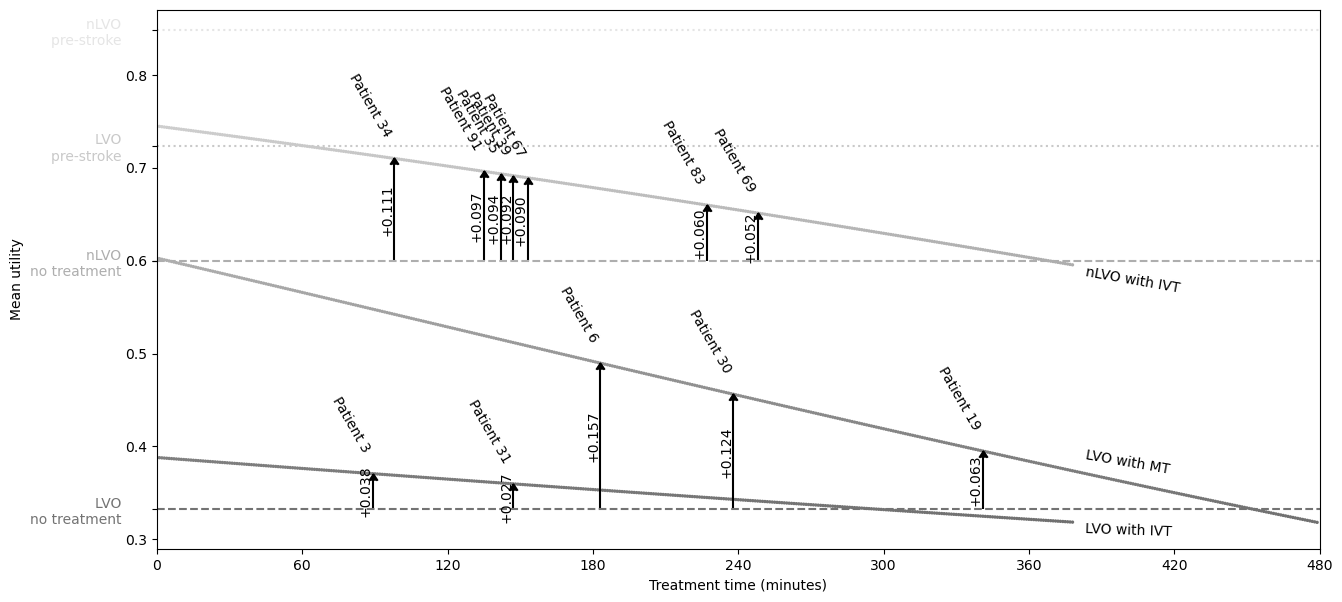

In [171]:
fig, ax = plt.subplots(figsize=(15, 7))

# Patients with nLVO and IVT:
plot_mRS_with_time(
    ax,
    time_shift_dict_nlvo_ivt['times'],
    time_shift_dict_nlvo_ivt['mean_utility_with_time'],
    time_shift_dict_nlvo_ivt['mean_utility_with_time_colour_list'],
    ivt_time_no_effect_mins,
    time_shift_dict_nlvo_ivt['mean_utility_no_treatment'],
    time_shift_dict_nlvo_ivt['mean_utility_pre_stroke'],
    time_shift_dict_nlvo_ivt['mean_utility_no_treatment_colour'],
    time_shift_dict_nlvo_ivt['mean_utility_pre_stroke_colour'],
    time_shift_dict_nlvo_ivt['times_patients'],
    time_shift_dict_nlvo_ivt['mean_utility_patients'],
    time_shift_dict_nlvo_ivt['mean_utility_shift_patients'],
    patient_labels=[f'Patient {i}' for i in time_shift_dict_nlvo_ivt['inds_patients']],
    type_str='utility'
    )



# Patients with LVO and IVT:

plot_mRS_with_time(
    ax,
    time_shift_dict_lvo_ivt['times'],
    time_shift_dict_lvo_ivt['mean_utility_with_time'],
    time_shift_dict_lvo_ivt['mean_utility_with_time_colour_list'],
    ivt_time_no_effect_mins,
    time_shift_dict_lvo_ivt['mean_utility_no_treatment'],
    time_shift_dict_lvo_ivt['mean_utility_pre_stroke'],
    time_shift_dict_lvo_ivt['mean_utility_no_treatment_colour'],
    time_shift_dict_lvo_ivt['mean_utility_pre_stroke_colour'],
    time_shift_dict_lvo_ivt['times_patients'],
    time_shift_dict_lvo_ivt['mean_utility_patients'],
    time_shift_dict_lvo_ivt['mean_utility_shift_patients'],
    patient_labels=[f'Patient {i}' for i in time_shift_dict_lvo_ivt['inds_patients']],
    type_str='utility'
    )


# Patients with LVO and MT:

plot_mRS_with_time(
    ax,
    time_shift_dict_lvo_mt['times'],
    time_shift_dict_lvo_mt['mean_utility_with_time'],
    time_shift_dict_lvo_mt['mean_utility_with_time_colour_list'],
    mt_time_no_effect_mins,
    time_shift_dict_lvo_mt['mean_utility_no_treatment'],
    time_shift_dict_lvo_mt['mean_utility_pre_stroke'],
    time_shift_dict_lvo_mt['mean_utility_no_treatment_colour'],
    time_shift_dict_lvo_mt['mean_utility_pre_stroke_colour'],
    time_shift_dict_lvo_mt['times_patients'],
    time_shift_dict_lvo_mt['mean_utility_patients'],
    time_shift_dict_lvo_mt['mean_utility_shift_patients'],
    patient_labels=[f'Patient {i}' for i in time_shift_dict_lvo_mt['inds_patients']],
    type_str='utility'
    )

type_str = 'utility'
occlusion_str_list = ['LVO', 'nLVO']
for i, d in enumerate([time_shift_dict_lvo_mt, time_shift_dict_nlvo_ivt]):
    # Horizontal lines for start and end values:
    ax.hlines(d['mean_utility_no_treatment'], 0, mt_time_no_effect_mins, 
              color=d['mean_utility_no_treatment_colour'], linestyle='--')
    ax.hlines(d['mean_utility_pre_stroke'], 0, mt_time_no_effect_mins, 
              color=d['mean_utility_pre_stroke_colour'], linestyle=':')

#     # Labels for the start and end values:
#     ax.scatter(mt_time_no_effect_mins+10, d['mean_utility_no_treatment'], 
#                marker=0, color='k', linewidth=0.7)
#     ax.scatter(mt_time_no_effect_mins+10, d['mean_utility_pre_stroke'], 
#                marker=0, color='k', linewidth=0.7)
#     ax.annotate(occlusion_str_list[i] + f'\nNo treatment\nmean {type_str}', 
#                 xy=(mt_time_no_effect_mins+12, d['mean_utility_no_treatment']), 
#                 rotation=0, va='center', ha='left')
#     ax.annotate(occlusion_str_list[i] + f'\nPre-stroke\nmean {type_str}', 
#                 xy=(mt_time_no_effect_mins+12, d['mean_utility_pre_stroke']), 
#                 rotation=0, va='center', ha='left')

ax.set_xticks(np.arange(0, mt_time_no_effect_mins+1, 60))
ax.set_xlim(0, mt_time_no_effect_mins)



yticks = ax.get_yticks().tolist()

yticks_to_add = [
    time_shift_dict_lvo_mt['mean_utility_no_treatment'],
    time_shift_dict_lvo_mt['mean_utility_pre_stroke'],
    time_shift_dict_nlvo_ivt['mean_utility_no_treatment'],
    time_shift_dict_nlvo_ivt['mean_utility_pre_stroke'],
    ]
yticklabels_to_add = [
     f'LVO      \nno treatment      ',
     f'LVO      \npre-stroke      ',
     f'nLVO      \nno treatment      ',
     f'nLVO      \npre-stroke      ',
    ]
ytick_colours = [
    time_shift_dict_lvo_mt['mean_utility_no_treatment_colour'],
    time_shift_dict_lvo_mt['mean_utility_pre_stroke_colour'],
    time_shift_dict_nlvo_ivt['mean_utility_no_treatment_colour'],
    time_shift_dict_nlvo_ivt['mean_utility_pre_stroke_colour'],
    ]
yticklabels = [f'{y:.1f}' for y in yticks] + yticklabels_to_add
yticks = yticks + yticks_to_add


ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

# Update colours of the y ticks:
yticks = ax.get_yticks()
for j, y in enumerate(yticks_to_add):
    i = np.where(yticks == y)[0][0]
    plt.gca().get_yticklabels()[i].set_color(ytick_colours[j]) 

ax.set_ylim(0.29, 0.87)
# ax.set_xlim(0, 480)

ax.annotate('nLVO with IVT', 
            xy=(ivt_time_no_effect_mins + 5, 
                np.nanmin(time_shift_dict_nlvo_ivt['mean_utility_with_time'])), 
            rotation=-10, va='top')
ax.annotate('LVO with IVT', 
            xy=(ivt_time_no_effect_mins + 5, 
                np.nanmin(time_shift_dict_lvo_ivt['mean_utility_with_time'])), 
            rotation=-2, va='top')
ax.annotate('LVO with MT',
            xy=(ivt_time_no_effect_mins + 5, 
                np.nanmin(time_shift_dict_lvo_mt['mean_utility_with_time']) + 0.08), 
            rotation=-10, va='top')

# ax.invert_yaxis()

# ax.set_ylim(0.8, 3.8)
# ax.set_yticks(np.arange(1.0, 3.8, 0.25))
# ax.set_title('nLVO treated with IVT')
plt.savefig('./clinical_outcome_worked_example/times_shifts_utility_combo.png', bbox_inches='tight')
plt.show()

## Input patient stats

In [54]:
n_nlvo = len(np.where(example_results['stroke_type_code'].values == 1)[0])
n_lvo = len(np.where(example_results['stroke_type_code'].values == 2)[0])
n_other = len(np.where(example_results['stroke_type_code'].values == 0)[0])

n_nlvo_ivt = len(np.where(
    (example_results['stroke_type_code'].values == 1) &
    (example_results['ivt_chosen_bool'].values == 1))[0])
n_nlvo_not_treated = n_nlvo - n_nlvo_ivt

n_lvo_ivt_only = len(np.where(
    (example_results['stroke_type_code'].values == 2) &
    (example_results['ivt_chosen_bool'].values == 1) &
    (example_results['mt_chosen_bool'].values == 0))[0])
n_lvo_mt_only = len(np.where(
    (example_results['stroke_type_code'].values == 2) &
    (example_results['ivt_chosen_bool'].values == 0) &
    (example_results['mt_chosen_bool'].values == 1))[0])
n_lvo_ivt_and_mt = len(np.where(
    (example_results['stroke_type_code'].values == 2) &
    (example_results['ivt_chosen_bool'].values == 1) &
    (example_results['mt_chosen_bool'].values == 1))[0])
n_lvo_not_treated = len(np.where(
    (example_results['stroke_type_code'].values == 2) &
    (example_results['ivt_chosen_bool'].values == 0) &
    (example_results['mt_chosen_bool'].values == 0))[0])

In [55]:
print(n_nlvo, n_lvo, n_other, n_nlvo_ivt, n_nlvo_not_treated, n_lvo_ivt_only, n_lvo_mt_only, n_lvo_ivt_and_mt, n_lvo_not_treated)

62 32 6 7 55 2 1 2 27


In [56]:
colour_other = 'k'
colour_nlvo = 'DimGray'
colour_lvo = 'Gainsboro'

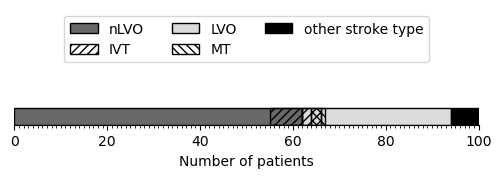

In [57]:
fig, ax = plt.subplots(figsize=(6, 1.5))

# Background bars for numbers of each stroke type and 
# Hatched bars for numbers treated:
# (in mixed order here for laziness - legend order is nicer like this)
ax.barh(0, n_nlvo, facecolor=colour_nlvo, edgecolor='k', left=0.0, label='nLVO', zorder=0)
ax.barh(0, n_nlvo_ivt, facecolor=(0, 0, 0, 0), edgecolor='k', left=n_nlvo_not_treated, hatch='////', label='IVT', zorder=1)

ax.barh(0, n_lvo, facecolor=colour_lvo, edgecolor='k', left=n_nlvo, label='LVO', zorder=0)
ax.barh(0, n_lvo_mt_only, facecolor=(0, 0, 0, 0), edgecolor='k', left=n_nlvo+n_lvo_ivt_only+n_lvo_ivt_and_mt, hatch='\\\\\\\\', label='MT', zorder=1)

ax.barh(0, n_other, facecolor=colour_other, edgecolor='k', left=n_lvo+n_nlvo, label='other stroke type', zorder=0)

ax.barh(0, n_lvo_ivt_only, facecolor=(0, 0, 0, 0), edgecolor='k', left=n_nlvo, hatch='////', zorder=1)
ax.barh(0, n_lvo_ivt_and_mt, facecolor=(0, 0, 0, 0), edgecolor='k', left=n_nlvo+n_lvo_ivt_only, hatch='////\\\\\\\\', zorder=1)
ax.set_ylim(-0.4, 5)
ax.set_yticks([])
ax.legend(loc='upper center', ncol=3)
ax.set_xlim(-0.1, len(example_results['stroke_type_code'].values)+0.1)
ax.set_xlabel('Number of patients')
ax.set_xticks(np.arange(0, len(example_results['stroke_type_code'].values)), minor=True)

for spine in ['top', 'left', 'right']:
    ax.spines[spine].set_visible(False)
plt.savefig('clinical_outcome_worked_example/patient_input_stats.png', bbox_inches='tight')

## Show full mRS distributions for all treated patients

### LVO with IVT

In [58]:
mask = (
    (example_results['ivt_chosen_bool'].values == 1) &
    (example_results['mt_chosen_bool'].values == 0) &
    (example_results['stroke_type_code'].values == 2)
    )

patient_numbers = np.where(mask == True)[0]

prefix = 'lvo_ivt'

each_patient_post_stroke_mrs_dist = results_by_stroke_type[prefix + '_each_patient_post_stroke_mrs_dist'][mask]
each_patient_post_stroke_mean_mrs = results_by_stroke_type[prefix + '_each_patient_post_stroke_mean_mrs'][mask] 
each_patient_post_stroke_mean_utility = results_by_stroke_type[prefix + '_each_patient_post_stroke_mean_utility'][mask] 
 
each_patient_mean_mrs_shift = results_by_stroke_type[prefix + '_each_patient_mean_mrs_shift'][mask] 
each_patient_mean_added_utility = results_by_stroke_type[prefix + '_each_patient_mean_added_utility'][mask] 

# Make colours
each_patient_post_stroke_mean_mrs_colour_list, each_patient_post_stroke_mean_utility_colour_list = make_colours(each_patient_post_stroke_mean_mrs, each_patient_post_stroke_mean_utility)


 # = results_by_stroke_type[prefix + '_untreated_mean_mrs'][mask] 
 # = results_by_stroke_type[prefix + '_no_effect_mean_mrs'][mask]
 # = results_by_stroke_type[prefix + '_untreated_mean_utility'][mask] 
 # = results_by_stroke_type[prefix + '_no_effect_mean_utility'][mask] 
 # = results_by_stroke_type[prefix + '_proportion_of_this_stroke_type_improved'][mask] 
 # = results_by_stroke_type[prefix + '_proportion_of_whole_cohort_improved'][mask] 
 # = results_by_stroke_type[prefix + '_mean_valid_patients_mean_mrs_shift'][mask] 
 # = results_by_stroke_type[prefix + '_mean_valid_patients_mean_added_utility'][mask] 
 # = results_by_stroke_type[prefix + '_treated_population_proportion_of_this_stroke_type_improved'][mask] 
 # = results_by_stroke_type[prefix + '_treated_population_proportion_of_whole_cohort_improved'][mask] 
 # = results_by_stroke_type[prefix + '_treated_population_mean_valid_patients_mean_mrs_shift'][mask] 
 # = results_by_stroke_type[prefix + '_treated_population_mean_valid_patients_mean_added_utility'][mask] 

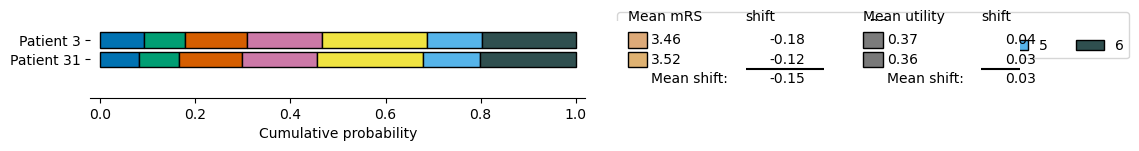

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(12, 0.5*len(each_patient_post_stroke_mrs_dist)), gridspec_kw={'width_ratios':[3.0, 2.5], 'wspace':0.05})

plot_bars_and_means(
    axs,
    each_patient_post_stroke_mrs_dist, 
    [f'Patient {i}' for i in patient_numbers], 
    each_patient_post_stroke_mean_mrs, 
    each_patient_post_stroke_mean_mrs_colour_list, 
    each_patient_post_stroke_mean_utility, 
    each_patient_post_stroke_mean_utility_colour_list,
    each_patient_mean_mrs_shift,
    each_patient_mean_added_utility
)
# plt.show()

plt.savefig('clinical_outcome_worked_example/mrs_dists_treated_lvo_ivt.png', bbox_inches='tight')

### What's the mean shift in mRS?

In [60]:
np.mean(each_patient_mean_mrs_shift)

-0.14888179431876702

In [61]:
np.mean(each_patient_mean_added_utility)

0.032697294771842605

These median values should be the mRS value at cumulative probability of 0.5 (halfway along x-axis).

In [62]:
for dist in each_patient_post_stroke_mrs_dist:
    cum_vals = np.append(0.0, dist)
    vals = np.diff(cum_vals)

    bin_above_median = np.where(cum_vals >= 0.5)[0][0]
    bin_below_median = np.where(cum_vals < 0.5)[0][-1]
    median = bin_below_median +  (0.5 - cum_vals[bin_below_median]) / (cum_vals[bin_above_median] - cum_vals[bin_below_median])
    print(median)

4.149458644209915
4.198029696701336


### LVO with MT

In [63]:
mask = (
    (example_results['mt_chosen_bool'].values == 1) &
    (example_results['stroke_type_code'].values == 2)
    )

patient_numbers = np.where(mask == True)[0]

prefix = 'lvo_mt'

each_patient_post_stroke_mrs_dist = results_by_stroke_type[prefix + '_each_patient_post_stroke_mrs_dist'][mask]
each_patient_post_stroke_mean_mrs = results_by_stroke_type[prefix + '_each_patient_post_stroke_mean_mrs'][mask] 
each_patient_post_stroke_mean_utility = results_by_stroke_type[prefix + '_each_patient_post_stroke_mean_utility'][mask] 
 
each_patient_mean_mrs_shift = results_by_stroke_type[prefix + '_each_patient_mean_mrs_shift'][mask] 
each_patient_mean_added_utility = results_by_stroke_type[prefix + '_each_patient_mean_added_utility'][mask] 

# Make colours
each_patient_post_stroke_mean_mrs_colour_list, each_patient_post_stroke_mean_utility_colour_list = make_colours(each_patient_post_stroke_mean_mrs, each_patient_post_stroke_mean_utility)


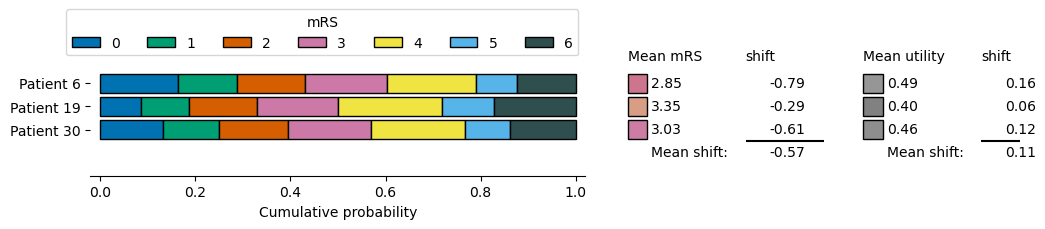

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(12, 0.5*len(each_patient_post_stroke_mrs_dist)), gridspec_kw={'width_ratios':[3.0, 2.5], 'wspace':0.05})

plot_bars_and_means(
    axs,
    each_patient_post_stroke_mrs_dist, 
    [f'Patient {i}' for i in patient_numbers], 
    each_patient_post_stroke_mean_mrs, 
    each_patient_post_stroke_mean_mrs_colour_list, 
    each_patient_post_stroke_mean_utility, 
    each_patient_post_stroke_mean_utility_colour_list,
    each_patient_mean_mrs_shift,
    each_patient_mean_added_utility
)
# plt.show()
axs[0].legend(bbox_to_anchor=(1.0, 1.5), ncol=7, title='mRS')

plt.savefig('clinical_outcome_worked_example/mrs_dists_treated_lvo_mt.png', bbox_inches='tight')

### nLVO with IVT

In [65]:
mask = (
    (example_results['ivt_chosen_bool'].values == 1) &
    (example_results['stroke_type_code'].values == 1)
    )

patient_numbers = np.where(mask == True)[0]

prefix = 'nlvo_ivt'

each_patient_post_stroke_mrs_dist = results_by_stroke_type[prefix + '_each_patient_post_stroke_mrs_dist'][mask]
each_patient_post_stroke_mean_mrs = results_by_stroke_type[prefix + '_each_patient_post_stroke_mean_mrs'][mask] 
each_patient_post_stroke_mean_utility = results_by_stroke_type[prefix + '_each_patient_post_stroke_mean_utility'][mask] 
 
each_patient_mean_mrs_shift = results_by_stroke_type[prefix + '_each_patient_mean_mrs_shift'][mask] 
each_patient_mean_added_utility = results_by_stroke_type[prefix + '_each_patient_mean_added_utility'][mask] 

# Make colours
each_patient_post_stroke_mean_mrs_colour_list, each_patient_post_stroke_mean_utility_colour_list = make_colours(each_patient_post_stroke_mean_mrs, each_patient_post_stroke_mean_utility)

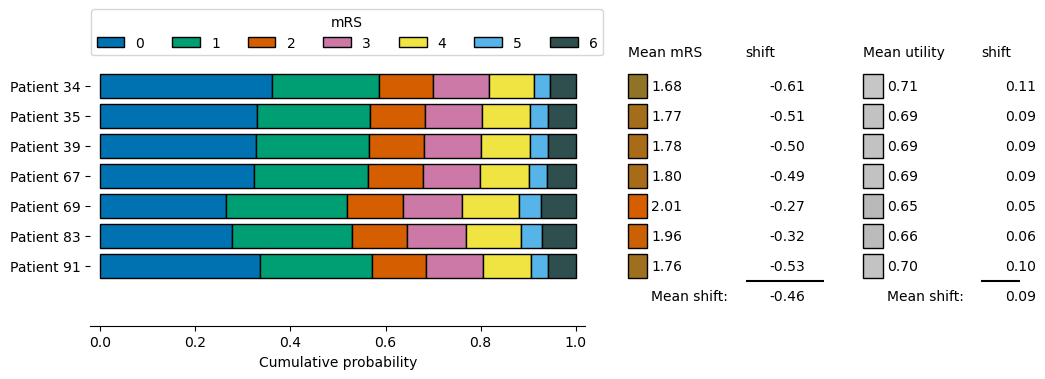

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(12, 0.5*len(each_patient_post_stroke_mrs_dist)), gridspec_kw={'width_ratios':[3.0, 2.5], 'wspace':0.05})

plot_bars_and_means(
    axs,
    each_patient_post_stroke_mrs_dist, 
    [f'Patient {i}' for i in patient_numbers], 
    each_patient_post_stroke_mean_mrs, 
    each_patient_post_stroke_mean_mrs_colour_list, 
    each_patient_post_stroke_mean_utility, 
    each_patient_post_stroke_mean_utility_colour_list,
    each_patient_mean_mrs_shift,
    each_patient_mean_added_utility
)
# plt.show()

plt.savefig('clinical_outcome_worked_example/mrs_dists_treated_nlvo_ivt.png', bbox_inches='tight')

# Whole patient array

In [67]:
patient_array_outcomes

{'each_patient_post_stroke_mrs_dist': array([[0.05      , 0.129     , 0.265     , 0.429     , 0.676     ,
         0.811     , 1.        ],
        [0.05      , 0.129     , 0.265     , 0.429     , 0.676     ,
         0.811     , 1.        ],
        [0.05      , 0.129     , 0.265     , 0.429     , 0.676     ,
         0.811     , 1.        ],
        [0.09280426, 0.17929425, 0.30908967, 0.46719978, 0.68665997,
         0.80369699, 1.        ],
        [0.05      , 0.129     , 0.265     , 0.429     , 0.676     ,
         0.811     , 1.        ],
        [0.05      , 0.129     , 0.265     , 0.429     , 0.676     ,
         0.811     , 1.        ],
        [0.16464373, 0.28773457, 0.43117949, 0.60401529, 0.78922481,
         0.87608733, 1.        ],
        [0.05      , 0.129     , 0.265     , 0.429     , 0.676     ,
         0.811     , 1.        ],
        [0.05      , 0.129     , 0.265     , 0.429     , 0.676     ,
         0.811     , 1.        ],
        [0.05      , 0.129     , 0.2

In [68]:
patient_numbers = np.arange(len(example_results['stroke_type_code']))

each_patient_post_stroke_mrs_dist = patient_array_outcomes['each_patient_post_stroke_mrs_dist']
each_patient_post_stroke_mean_mrs = patient_array_outcomes['each_patient_post_stroke_mean_mrs']
each_patient_post_stroke_mean_utility = patient_array_outcomes['each_patient_post_stroke_mean_utility']
 
each_patient_mean_mrs_shift = patient_array_outcomes['each_patient_mean_mrs_shift']
each_patient_mean_added_utility = patient_array_outcomes['each_patient_mean_added_utility']

# Make colours
each_patient_post_stroke_mean_mrs_colour_list, each_patient_post_stroke_mean_utility_colour_list = make_colours(each_patient_post_stroke_mean_mrs, each_patient_post_stroke_mean_utility)

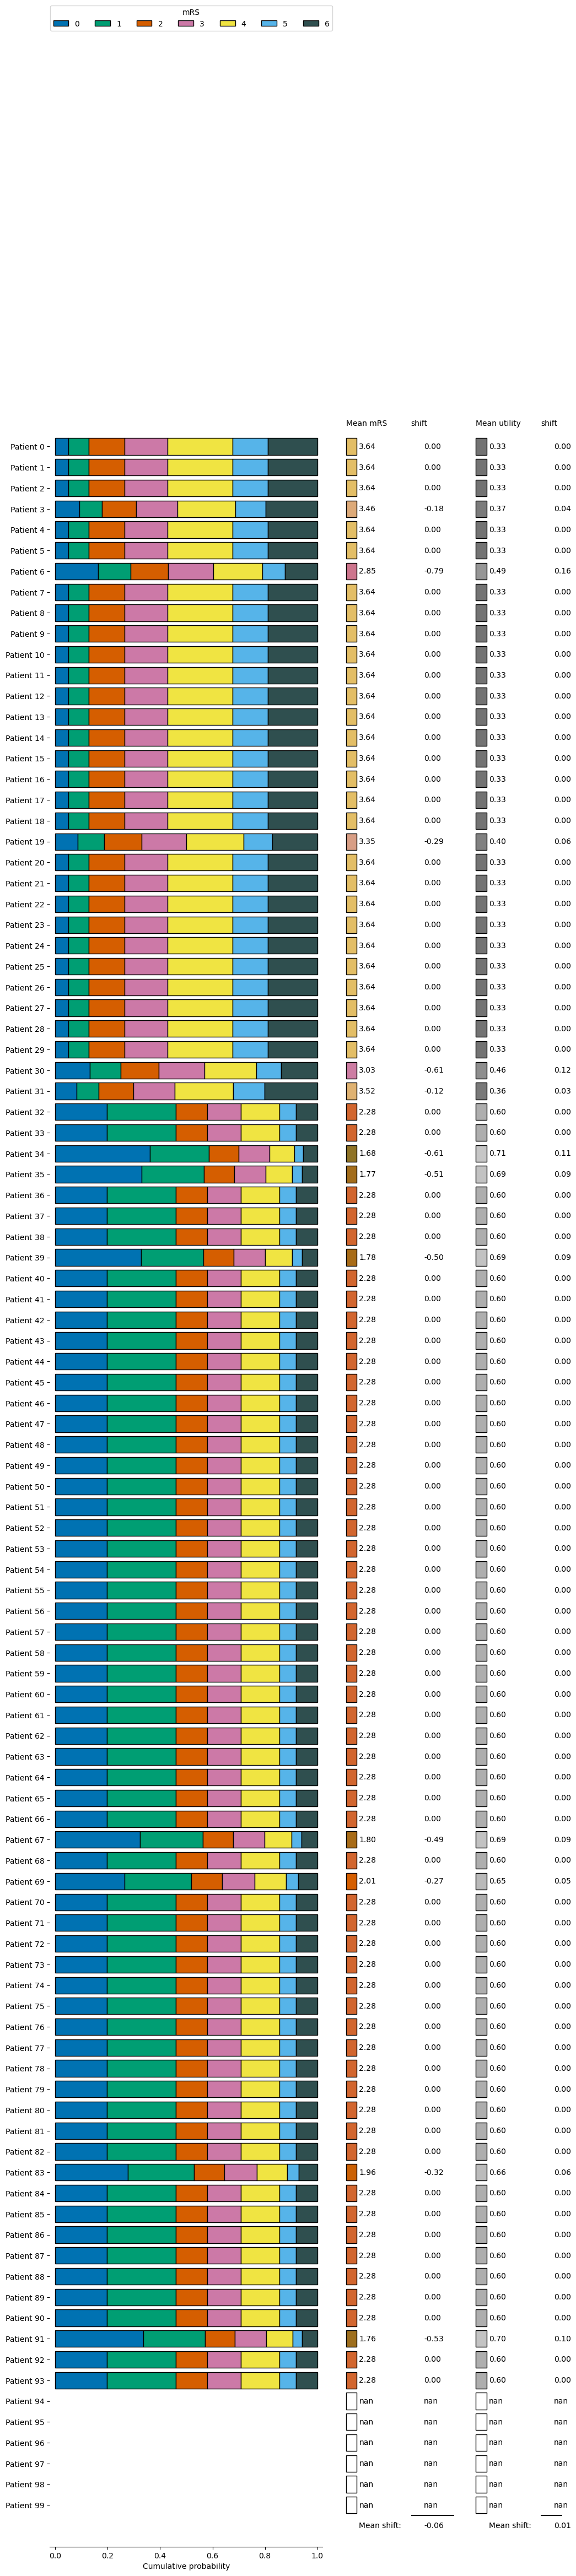

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(12, 0.5*len(each_patient_post_stroke_mrs_dist)), gridspec_kw={'width_ratios':[3.0, 2.5], 'wspace':0.05})

plot_bars_and_means(
    axs,
    each_patient_post_stroke_mrs_dist, 
    [f'Patient {i}' for i in patient_numbers], 
    each_patient_post_stroke_mean_mrs, 
    each_patient_post_stroke_mean_mrs_colour_list, 
    each_patient_post_stroke_mean_utility, 
    each_patient_post_stroke_mean_utility_colour_list,
    each_patient_mean_mrs_shift,
    each_patient_mean_added_utility
)
# plt.show()

plt.savefig('clinical_outcome_worked_example/mrs_dists_all_post_stroke.png', bbox_inches='tight')